# Modeling and Simulation in Python

Rabbit example

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [318]:
%matplotlib inline


from modsim import *

## Rabbit Redux

This notebook starts with a version of the rabbit population growth model and walks through some steps for extending it.

In the original model, we treat all rabbits as adults; that is, we assume that a rabbit is able to breed in the season after it is born.  In this notebook, we extend the model to include both juvenile and adult rabbits.

As an example, let's assume that rabbits take 3 seasons to mature.  We could model that process explicitly by counting the number of rabbits that are 1, 2, or 3 seasons old.  As an alternative, we can model just two stages, juvenile and adult.  In the simpler model, the maturation rate is 1/3 of the juveniles per season.

To implement this model, make these changes in the System object:

0.  Before you make any changes, run all cells and confirm your understand them.

1.  Then, add a second initial populations: `juvenile_pop0`, with value `0`.

2.  Add an additional variable, `mature_rate`, with the value `0.33`.

In [377]:
system = System(t0 = 2017, 
                t_end = 2037,
                jag_pop0 = 15000,
                jag_birth_rate = 0.205,
                jag_death_rate = 0.2,
                eater_pop0 = 5000,
                eater_birth_rate = 0.228,
                eater_death_rate = 0.2,
                ant_pop0 = 7000000,
                ant_birth_rate = 0.203,
                ant_death_rate = 0.2,
                eater_eat_rate = 1.6,
                jag_eat_rate = 0.01)
system

t0                     2017.000
t_end                  2037.000
jag_pop0              15000.000
jag_birth_rate            0.205
jag_death_rate            0.200
eater_pop0             5000.000
eater_birth_rate          0.228
eater_death_rate          0.200
ant_pop0            7000000.000
ant_birth_rate            0.203
ant_death_rate            0.200
eater_eat_rate            1.600
jag_eat_rate              0.010
dtype: float64

Now update `run_simulation` with the following changes:

1.  Add a second TimeSeries, named `juveniles`, to keep track of the juvenile population, and initialize it with `juvenile_pop0`.

2.  Inside the for loop, compute the number of juveniles that mature during each time step.

3.  Also inside the for loop, add a line that stores the number of juveniles in the new `TimeSeries`.  For simplicity, let's assume that only adult rabbits die.

4.  During each time step, subtract the number of maturations from the juvenile population and add it to the adult population.

5.  After the for loop, store the `juveniles` `TimeSeries` as a variable in `System`.

In [284]:
def run_simulation(system):
    """Runs a proportional growth model.
    
    Adds TimeSeries to `system` as `results`.
    
    system: System object with t0, t_end, p0,
            birth_rate and death_rate
    """
    jag = TimeSeries()
    jag[system.t0] = system.jag_pop0
    eater = TimeSeries()
    eater[system.t0] = system.eater_pop0
    ant = TimeSeries()
    ant[system.t0] = system.ant_pop0
    
    for t in linrange(system.t0, system.t_end):
        jag_births = system.jag_birth_rate * jag[t]
        jag_deaths = system.jag_death_rate * jag[t]
        eater_births = system.eater_birth_rate * eater[t]
        eater_deaths = system.eater_death_rate * eater[t]
        ant_births = system.ant_birth_rate * ant[t]
        ant_deaths = system.ant_death_rate * ant[t]
        jag_starved = jag[t] * system.jag_eat_rate / eater[t] * jag[t] / 5
        eater_killed = jag[t] * system.jag_eat_rate
        ant_killed = eater[t] * system.eater_eat_rate * 3
        eater_starved = eater[t] * system.eater_eat_rate / ant[t] * eater[t]
        jag[t+1] = jag[t] + jag_births - jag_deaths - jag_starved
        eater[t+1] = eater[t] + eater_births - eater_deaths - eater_killed - eater_starved
        ant[t+1] = ant[t] + ant_births - ant_deaths - ant_killed
        if(eater[t+1] < 1):
            eater[t+1] = 1
        if(jag[t+1] < 1):
            jag[t+1] = 1
        if(ant[t+1] < 1):
            ant[t+1] = 1
        
    system.jag = jag
    system.eater = eater
    system.ant = ant

Test your changes in `run_simulation`:

In [282]:
run_simulation(system)

Next, update `plot_results` to plot both the adult and juvenile `TimeSeries`.

In [358]:
def plot_results(system, title=None,xLabel = 'Year'):
    """Plot the estimates and the model.
    
    system: System object with `results`
    """
    newfig()
    plot(system.jag, 'bo-', label='Jaguars')
    plot(system.eater, 'go-', label='Anteaters')
    plot(system.ant / 1000, 'ro-', label='Ants (Billion)')
    decorate(xlabel=xLabel, 
             ylabel='Final Population',
             title=title,
             ylim = ylim(0,24000))

And test your updated version of `plot_results`.

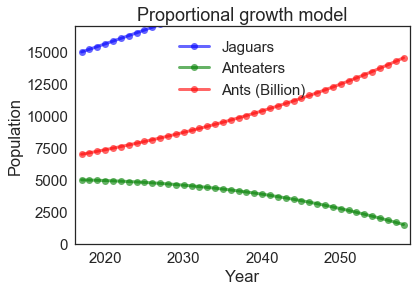

In [341]:
plot_results(system, title='Proportional growth model')

This notebook demonstrates the steps we recommend for starting your project:

1.  Start with one of the examples from the book, either by copying a notebook or pasting code into a new notebook.  Get the code working before you make any changes.

2.  Make one small change, and run the code again.

3.  Repeat step 2 until you have a basic implementation of your model.

If you start with working code that you understand and make small changes, you can avoid spending a lot of time debugging.

One you have a basic model working, you can think about what metrics to measure, what parameters to sweep, and how to use the model to predict, explain, or design.

### Bonus question

Suppose you only have room for 30 adult rabbits.  Whenever the adult population exceeds 30, you take any excess rabbits to market (as pets for kind children, of course).  Modify `run_simulation` to model this strategy.  What effect does it have on the behavior of the system?  You might have to run for more than 10 seasons to see what happens.

In [342]:
def sweep_jag_birth_rate_plot(start = 0.18,end = 0.22,num_steps = 41):
    for i in linspace(start,end,num_steps):
        system.jag_birth_rate = i
        run_simulation(system)
        plot_results(system, title=i)
        

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


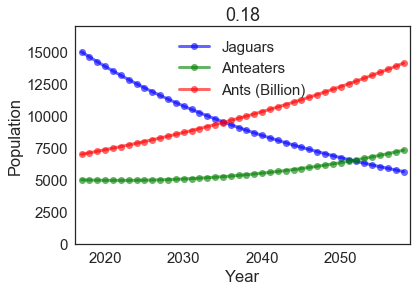

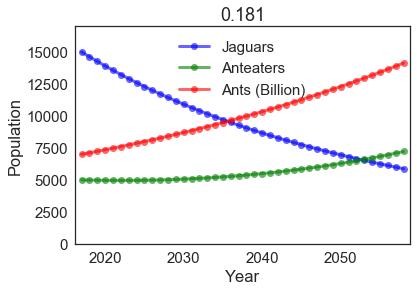

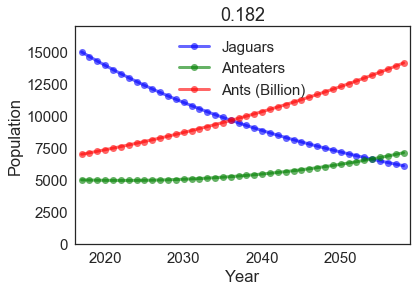

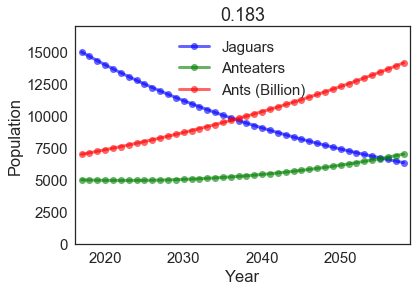

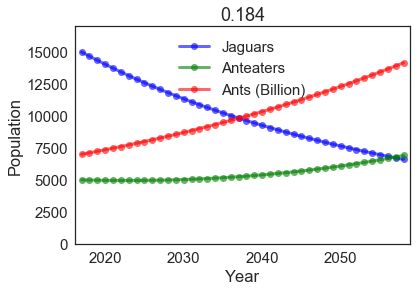

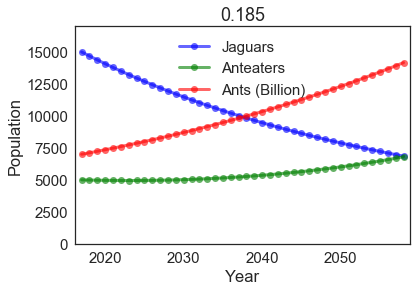

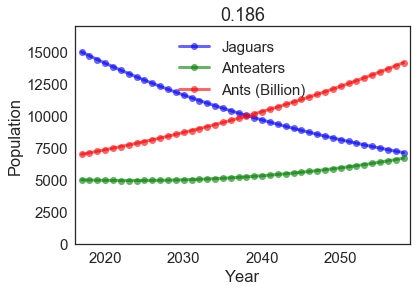

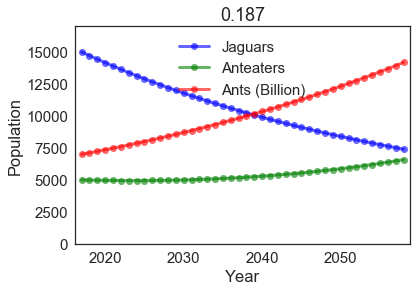

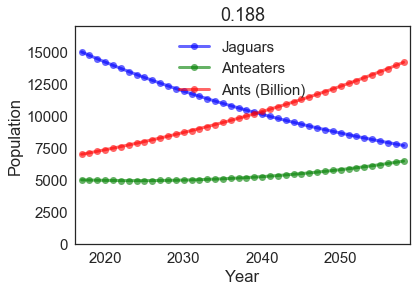

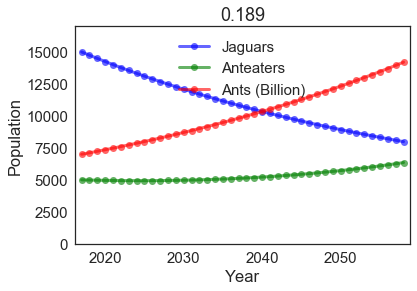

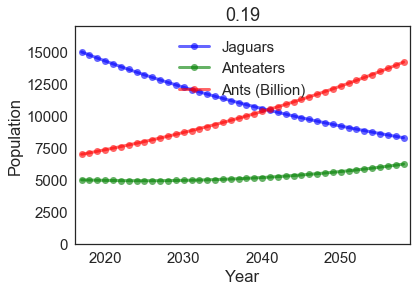

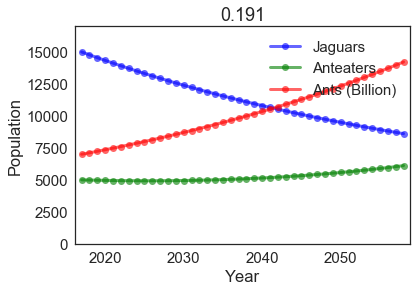

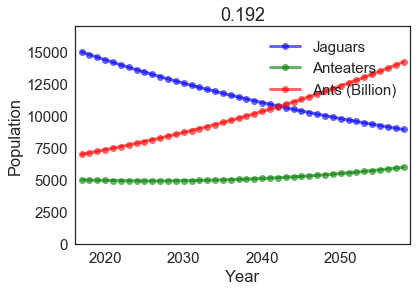

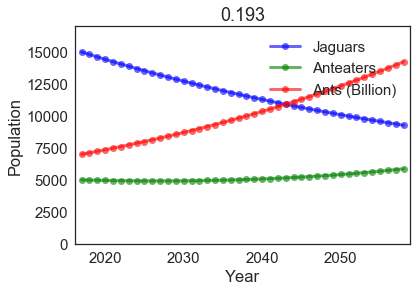

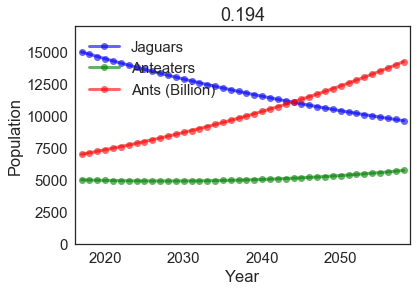

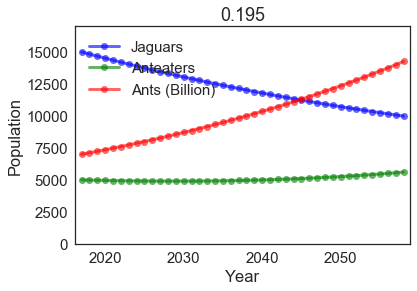

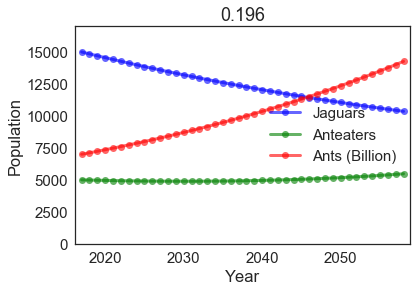

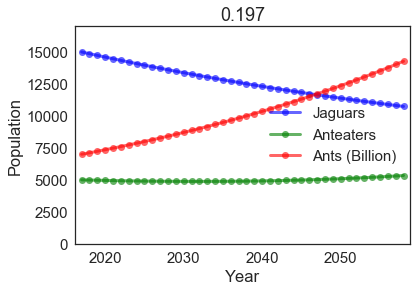

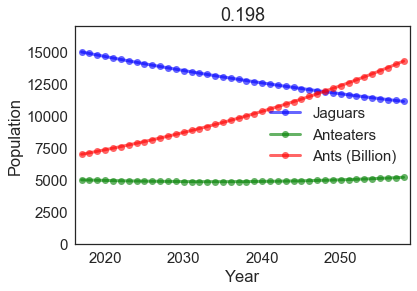

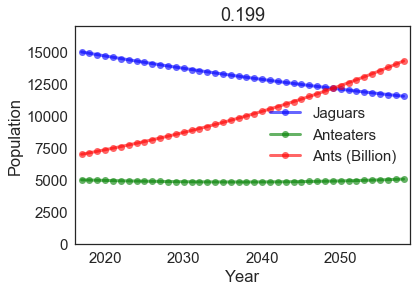

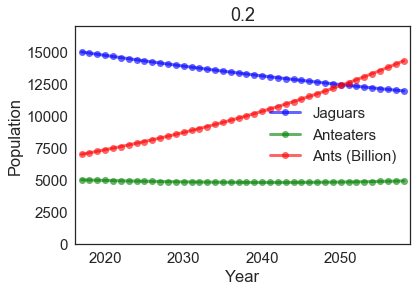

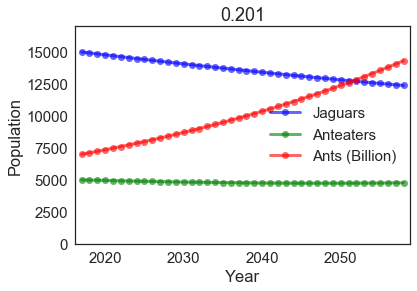

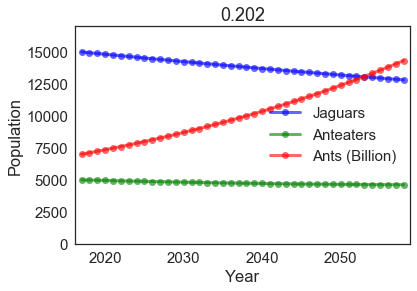

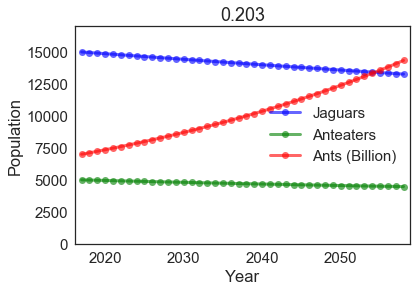

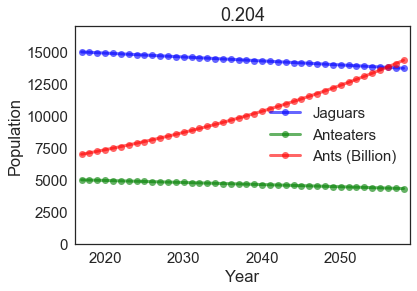

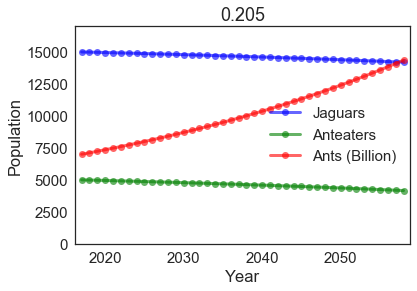

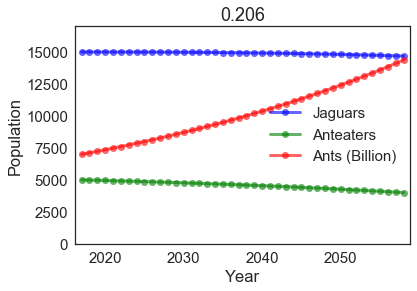

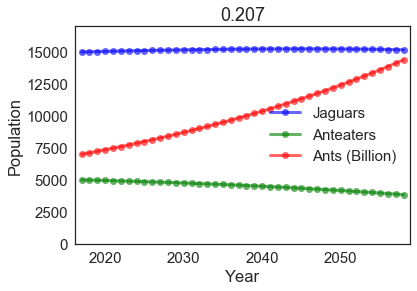

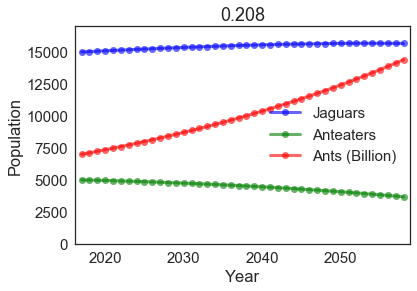

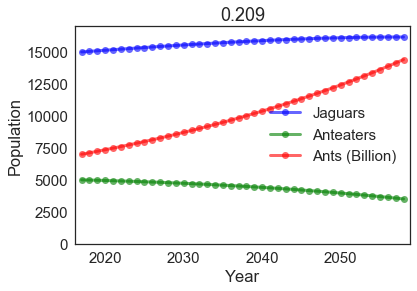

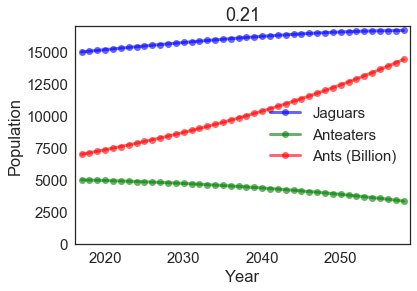

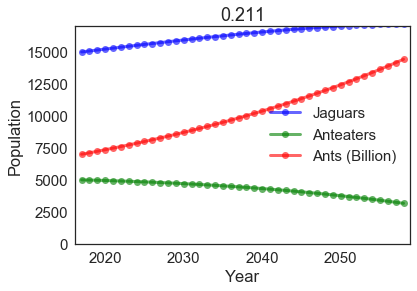

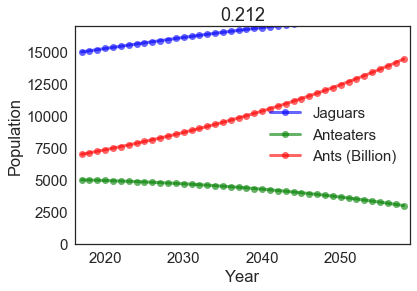

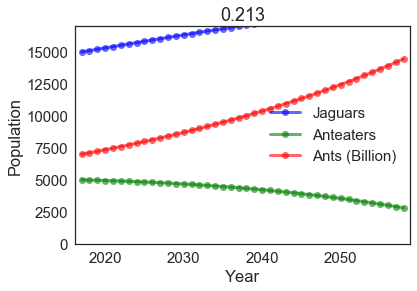

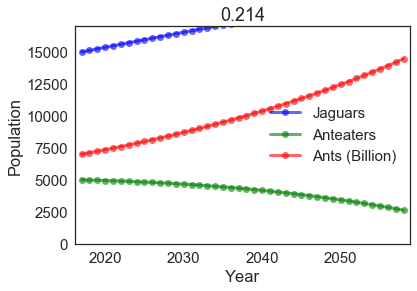

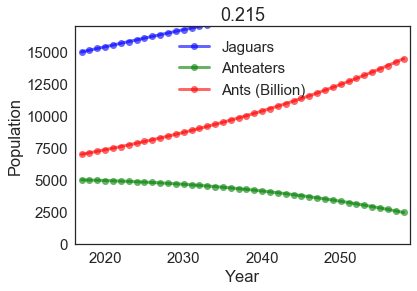

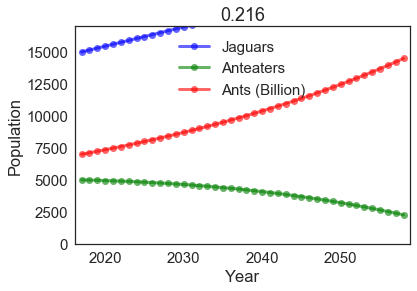

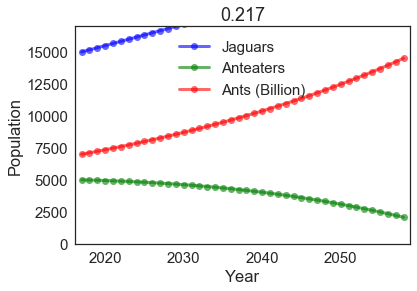

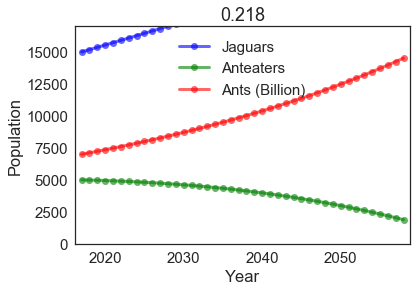

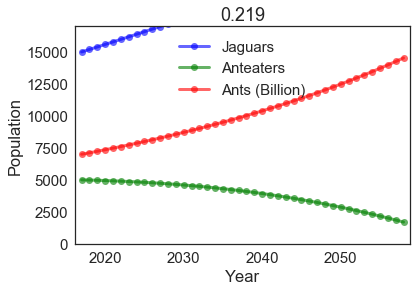

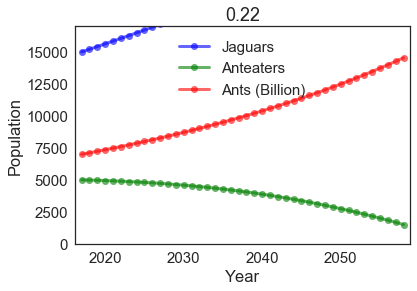

In [343]:
sweep_jag_birth_rate_plot()

In [348]:
def sweep_jag_birth_rate_table(start = 0.18,end = 0.22,num_steps = 41):
    animals = System()
    animals.jag = TimeSeries()
    animals.ant = TimeSeries()
    animals.eater = TimeSeries()
    for i in linspace(start,end,num_steps):
        system.jag_birth_rate = i
        run_simulation(system)
        animals.jag[i] = system.jag[system.t_end]
        animals.ant[i] = system.ant[system.t_end]
        animals.eater[i] = system.eater[system.t_end]
    return animals

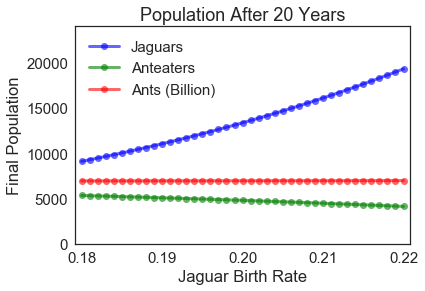

In [379]:
animals = sweep_jag_birth_rate_table()
plot_results(animals,title = 'Population After 20 Years',xLabel = 'Jaguar Birth Rate')

In [353]:
def sweep_jag_death_rate_table(start = 0.18,end = 0.22,num_steps = 41):
    animals = System()
    animals.jag = TimeSeries()
    animals.ant = TimeSeries()
    animals.eater = TimeSeries()
    for i in linspace(start,end,num_steps):
        system.jag_death_rate = i
        run_simulation(system)
        animals.jag[i] = system.jag[system.t_end]
        animals.ant[i] = system.ant[system.t_end]
        animals.eater[i] = system.eater[system.t_end]
    return animals

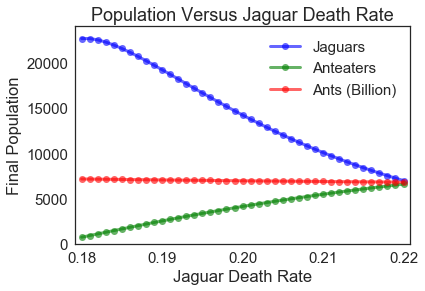

In [359]:
animals = sweep_jag_death_rate_table()
plot_results(animals,title = 'Population Versus Jaguar Death Rate',xLabel = 'Jaguar Death Rate')

In [306]:
def sweep_jag_death_rate_plot(start = 0.18,end = 0.22,num_steps = 41):
    for i in linspace(start,end,num_steps):
        system.jag_death_rate = i
        run_simulation(system)
        plot_results(system, title=i)

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


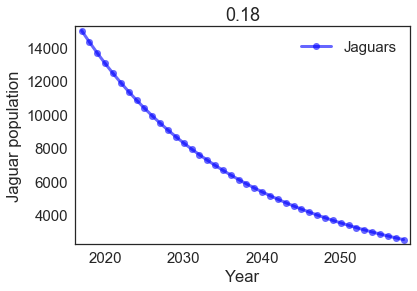

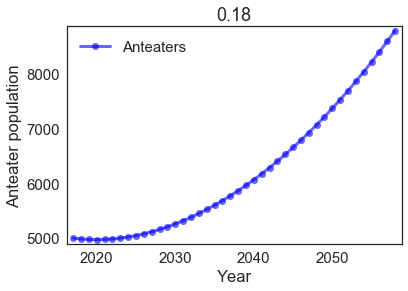

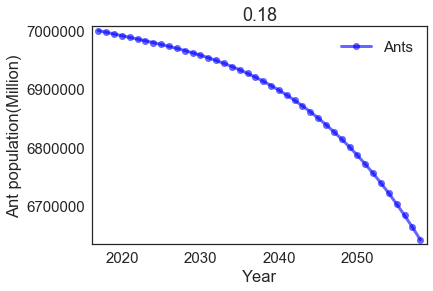

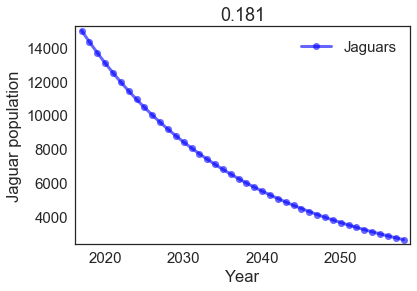

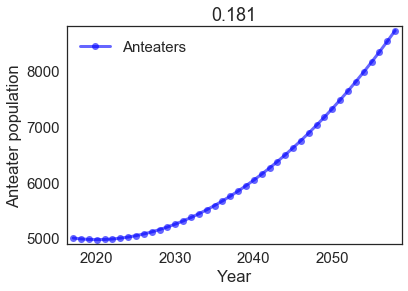

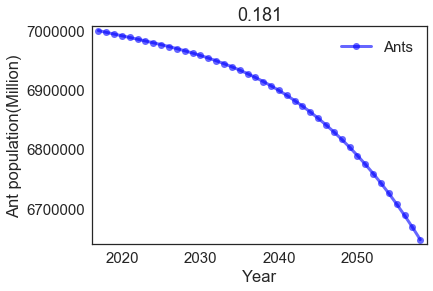

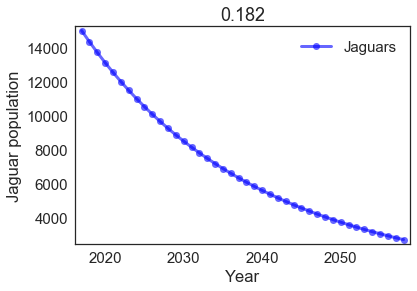

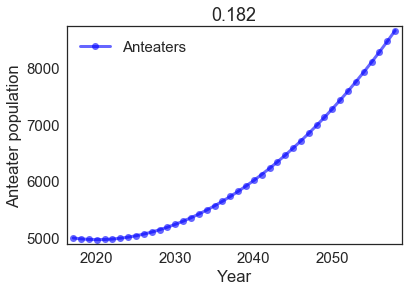

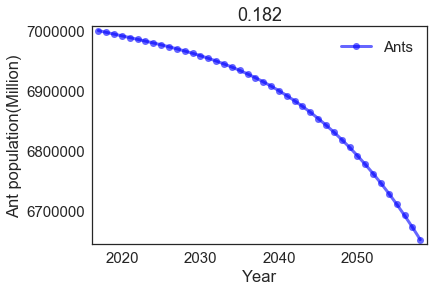

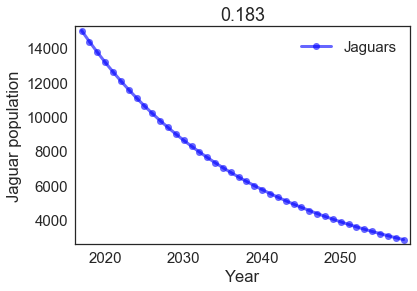

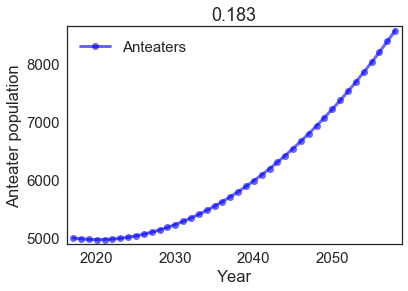

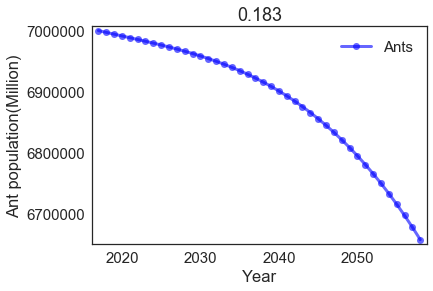

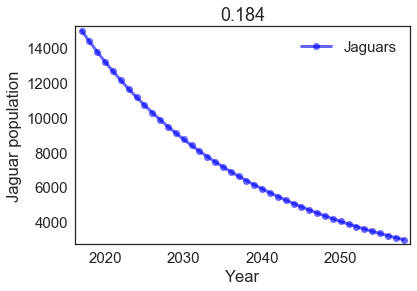

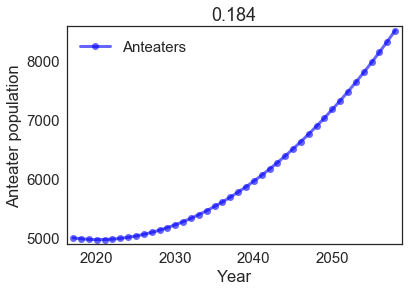

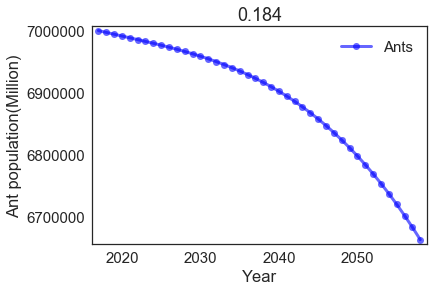

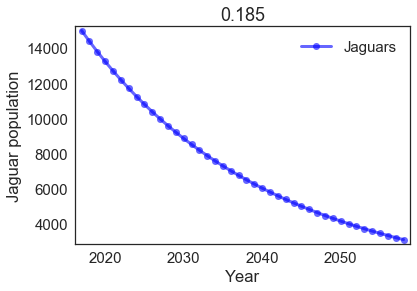

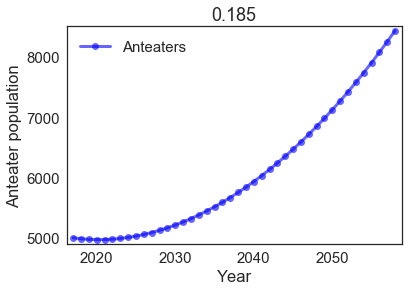

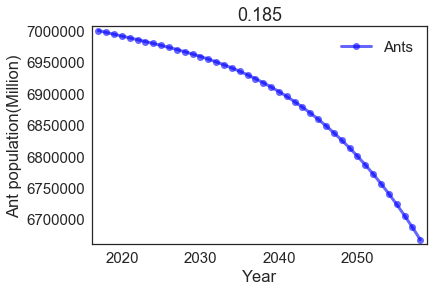

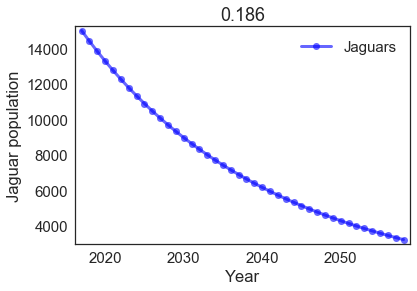

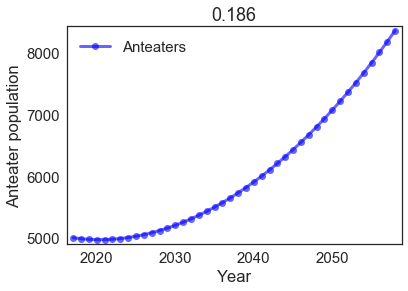

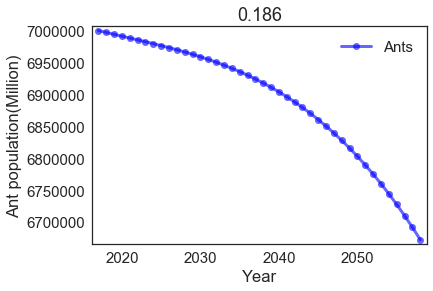

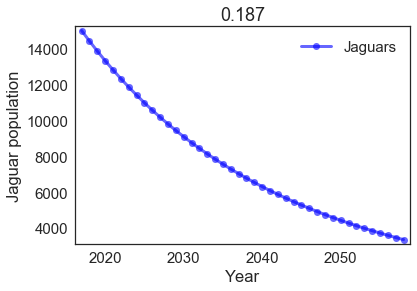

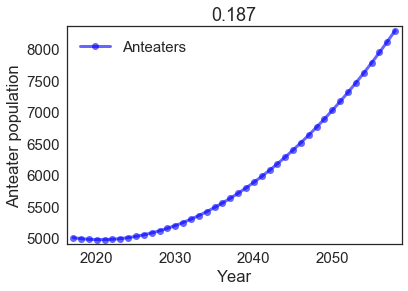

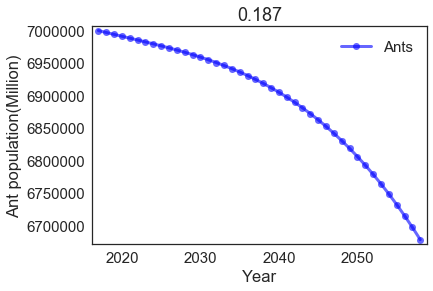

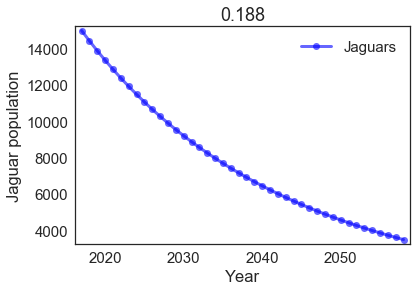

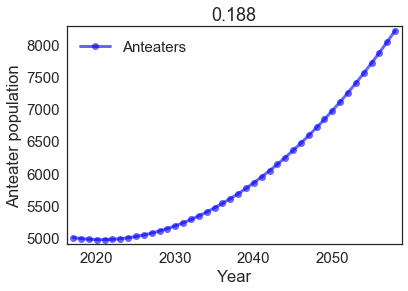

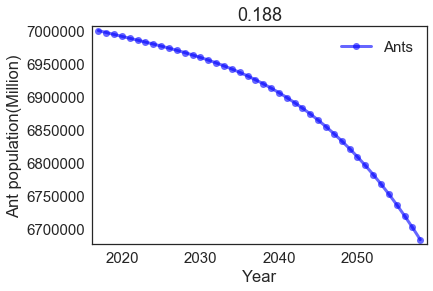

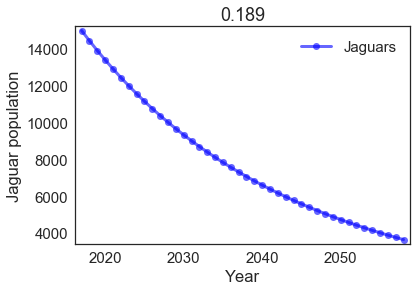

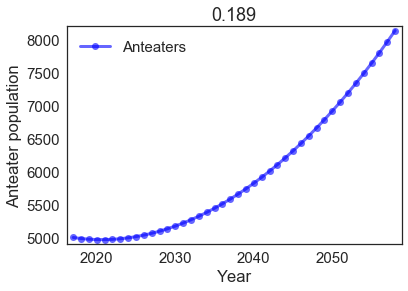

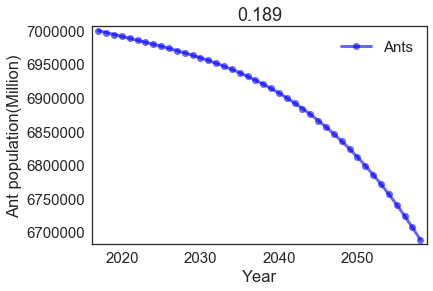

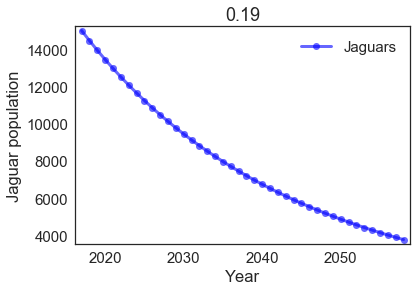

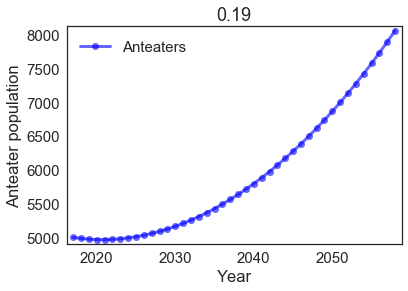

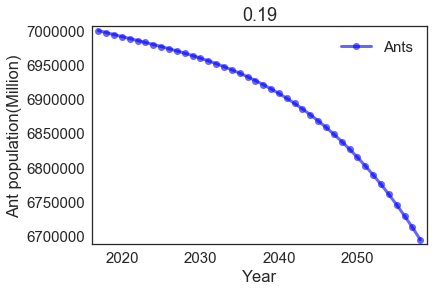

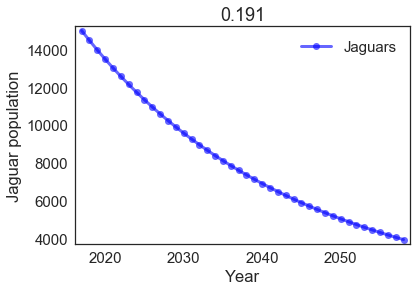

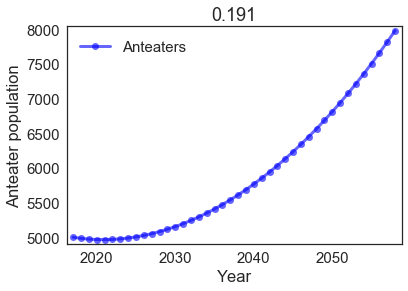

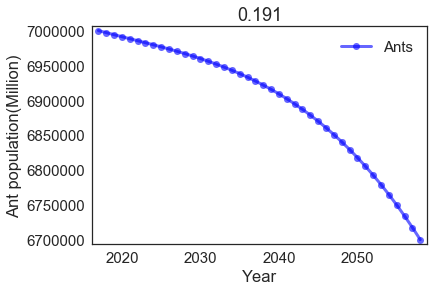

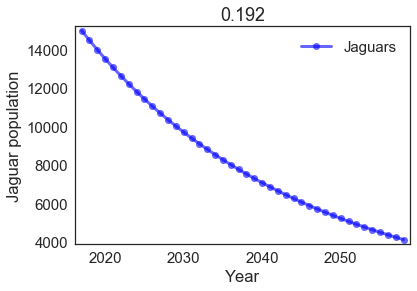

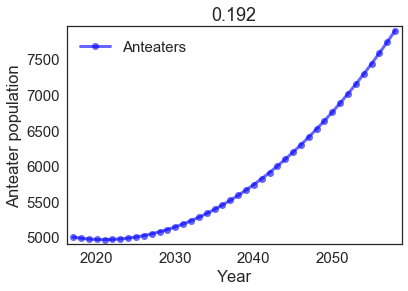

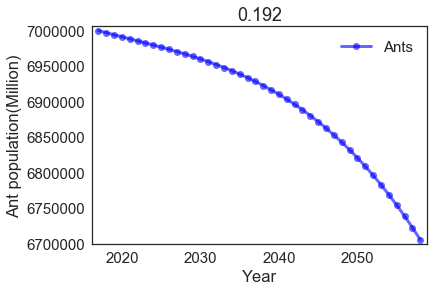

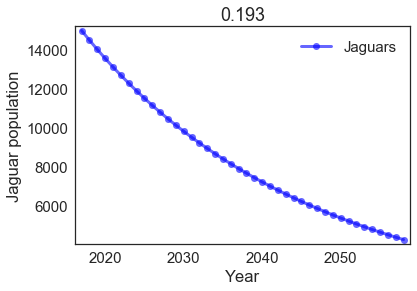

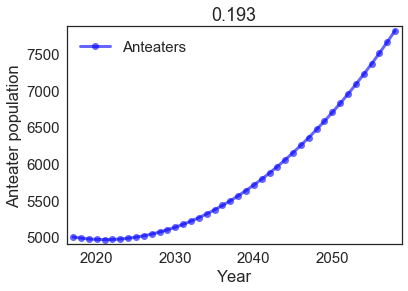

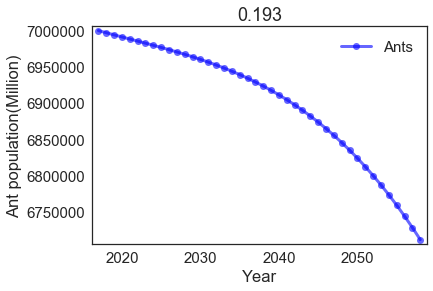

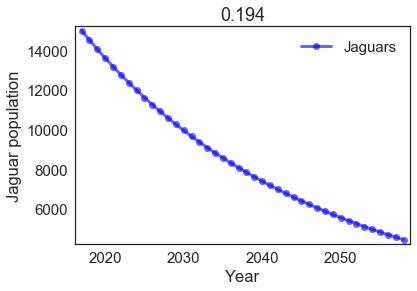

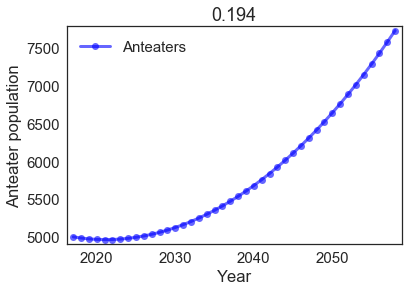

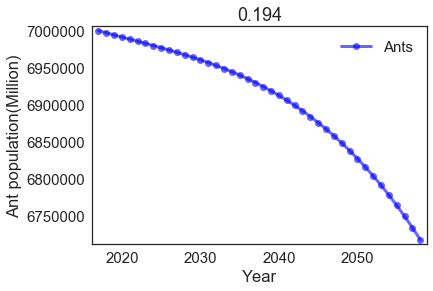

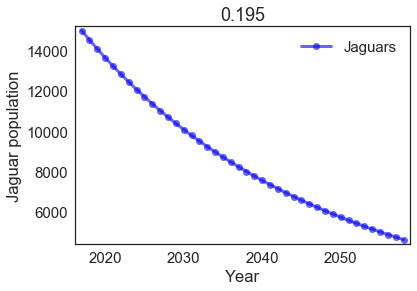

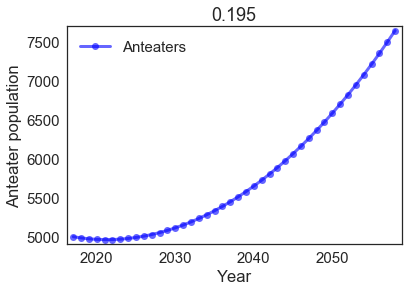

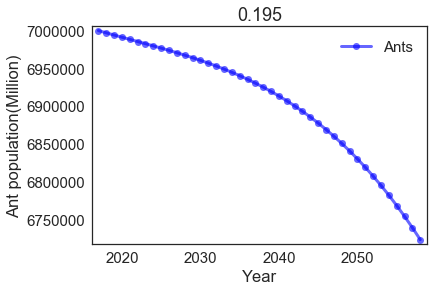

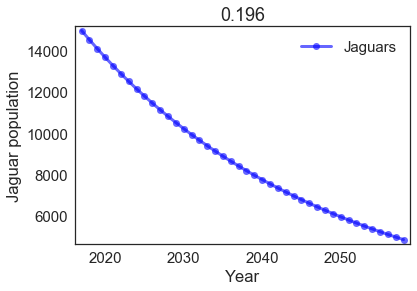

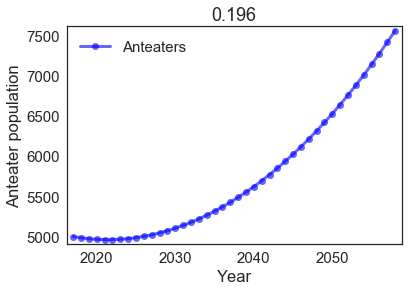

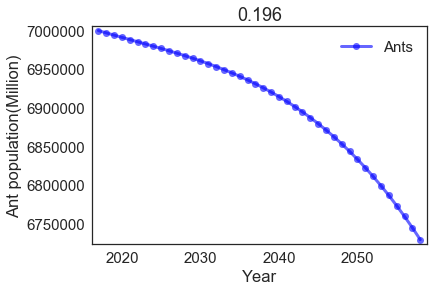

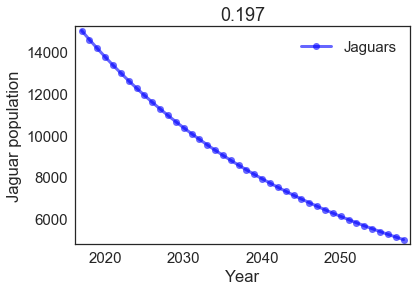

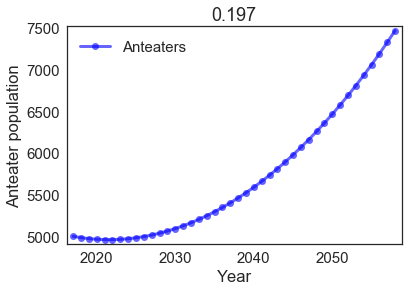

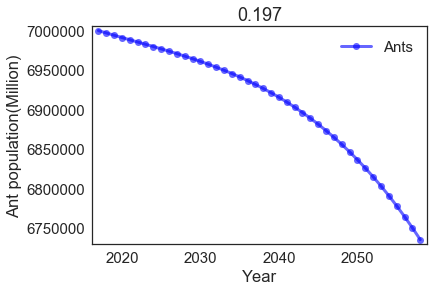

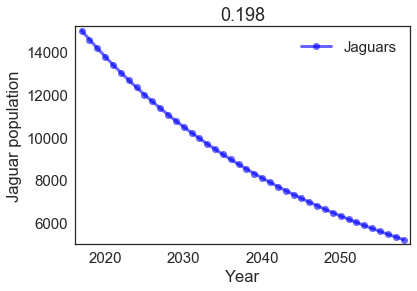

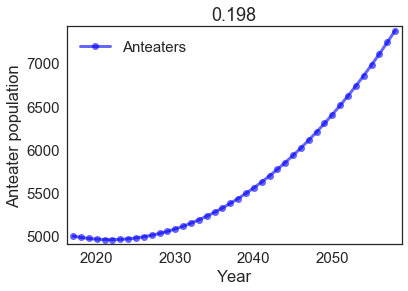

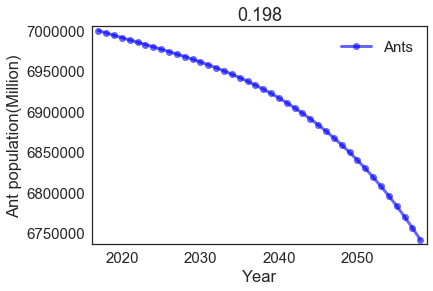

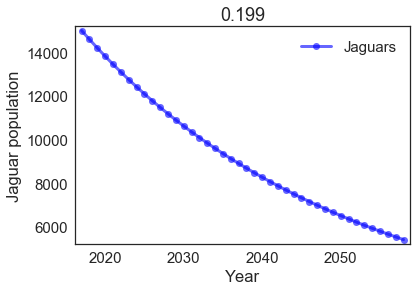

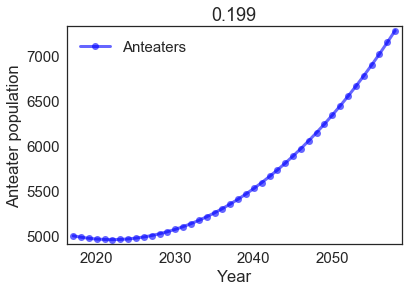

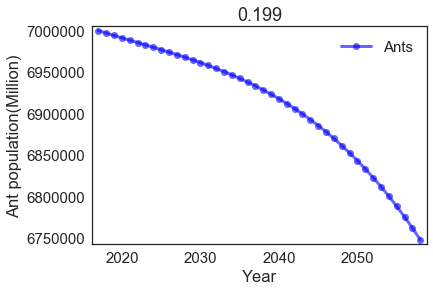

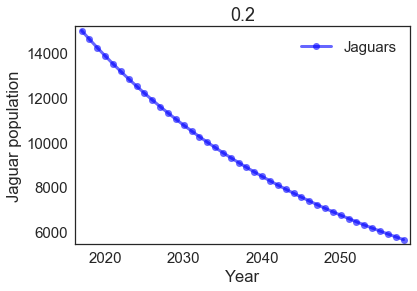

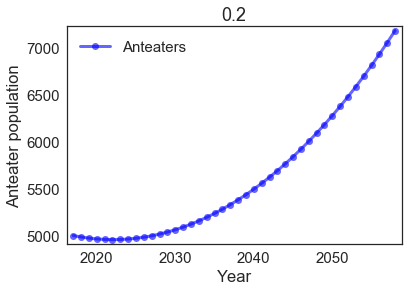

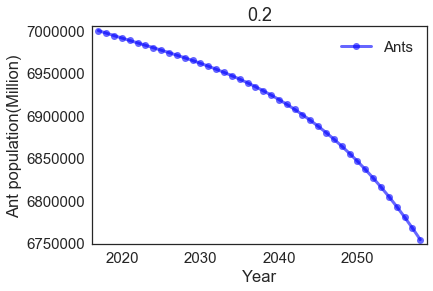

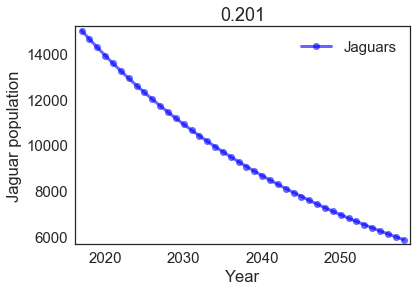

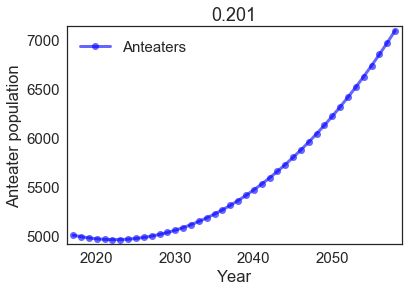

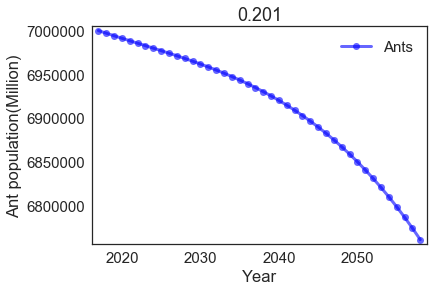

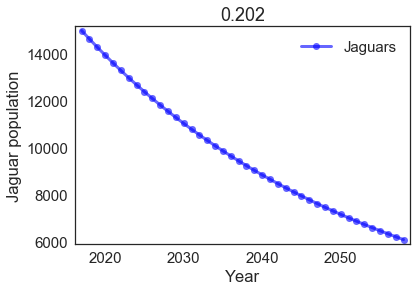

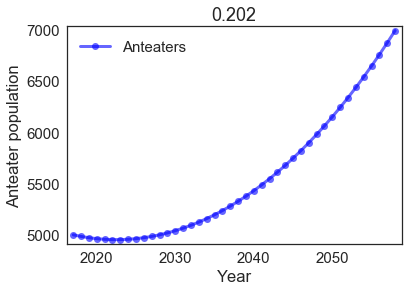

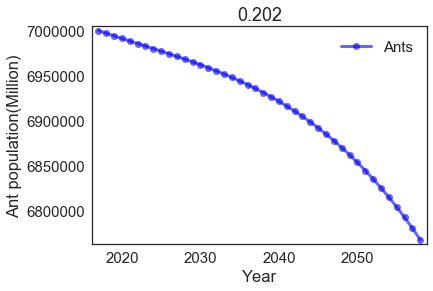

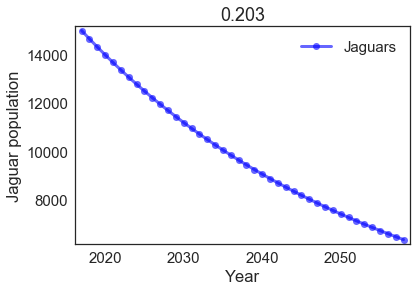

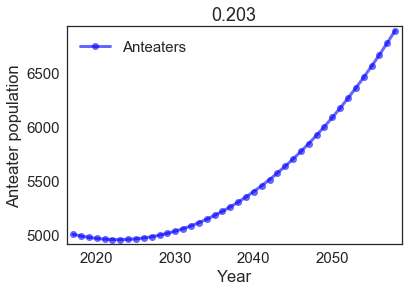

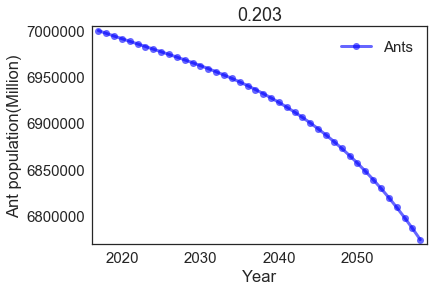

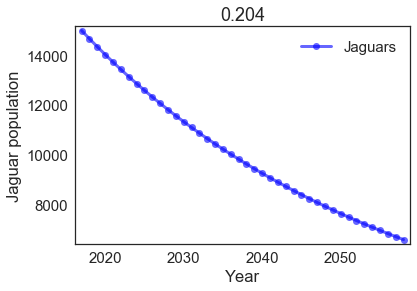

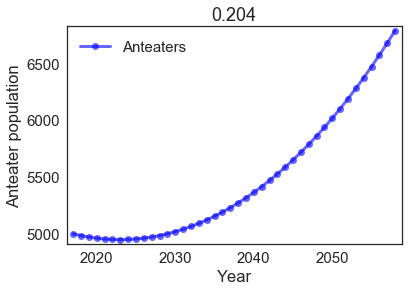

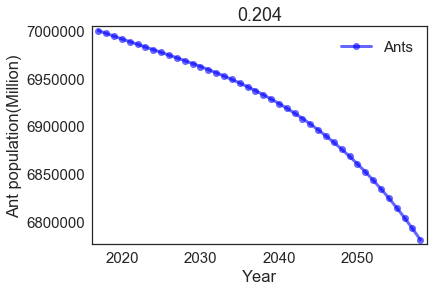

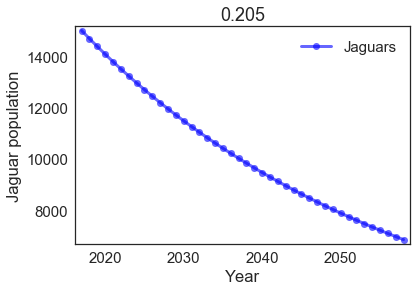

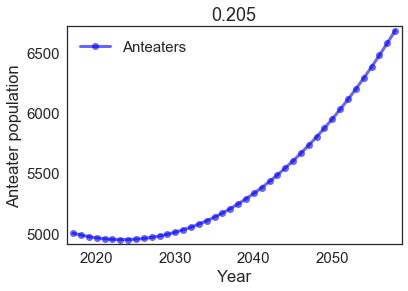

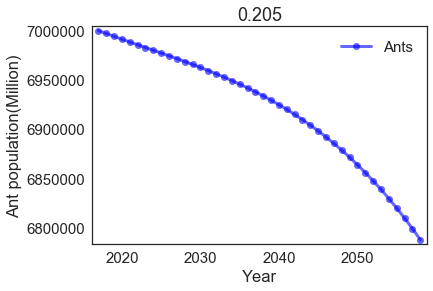

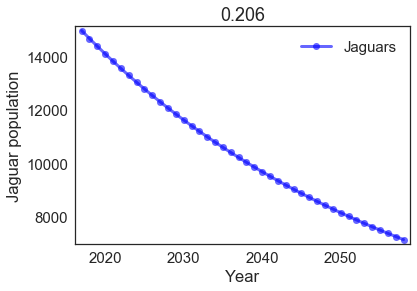

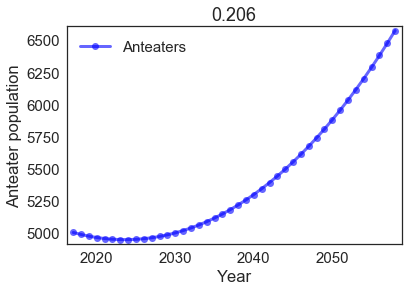

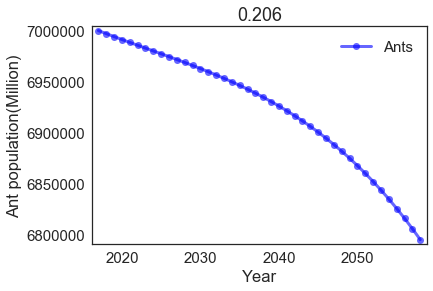

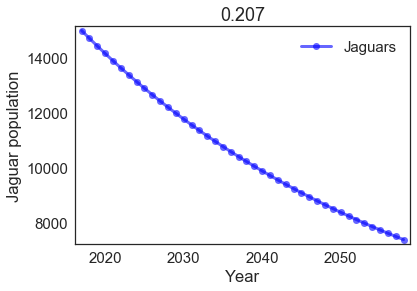

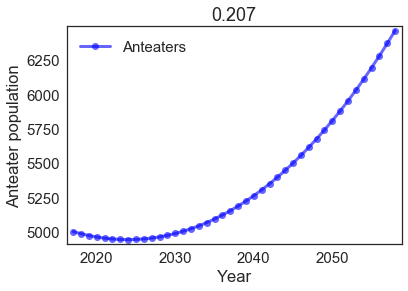

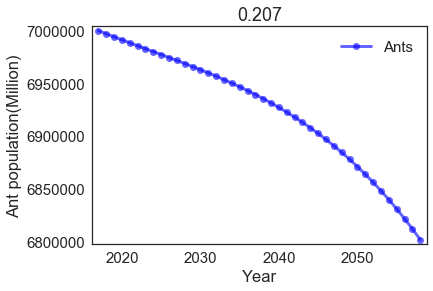

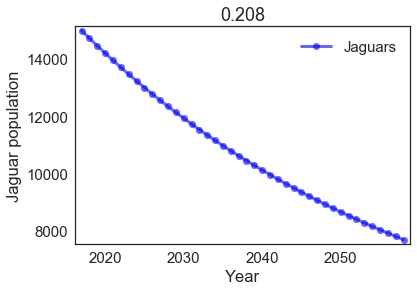

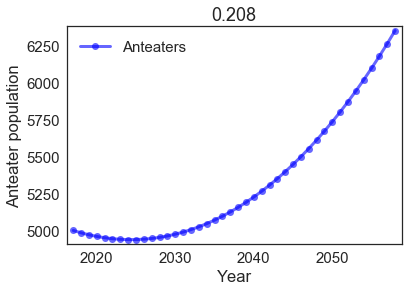

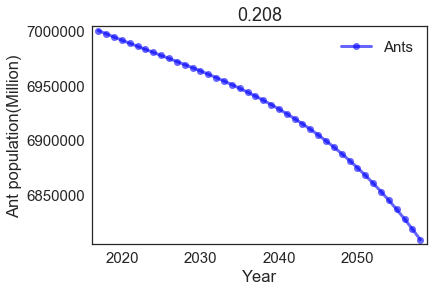

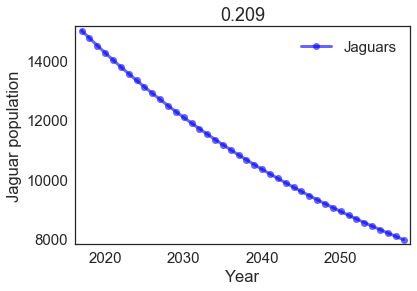

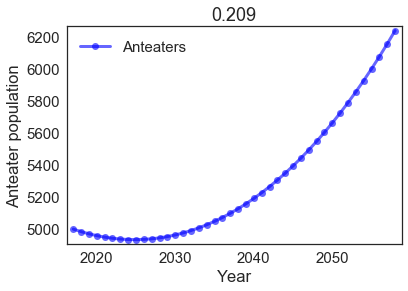

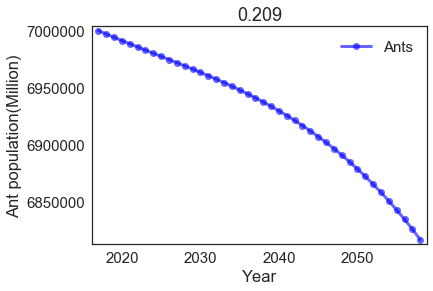

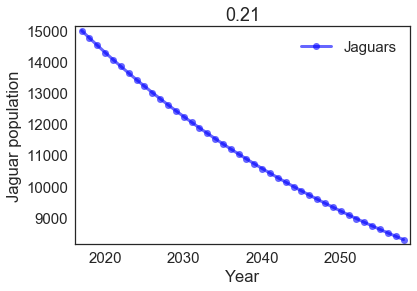

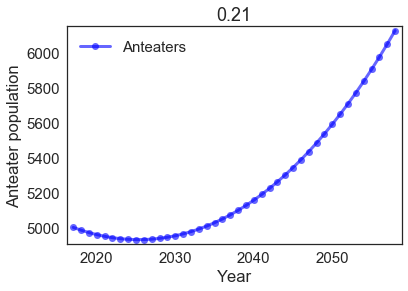

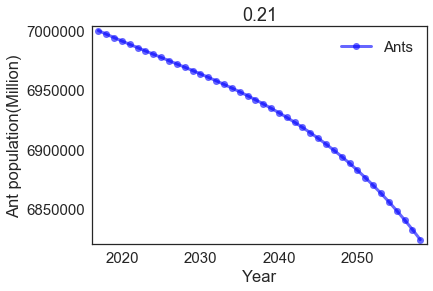

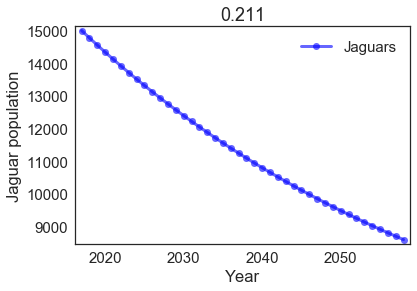

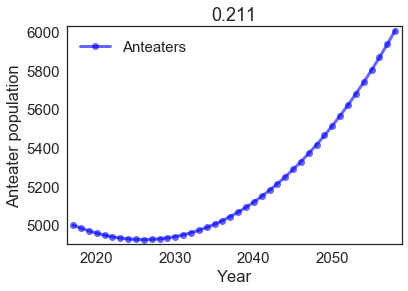

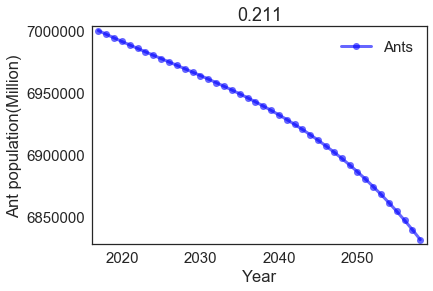

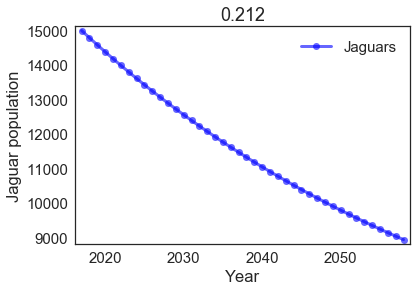

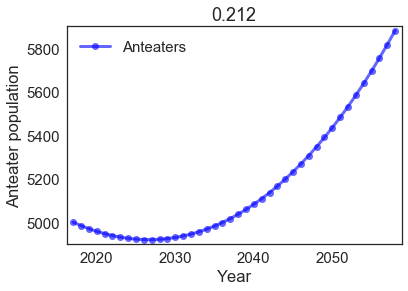

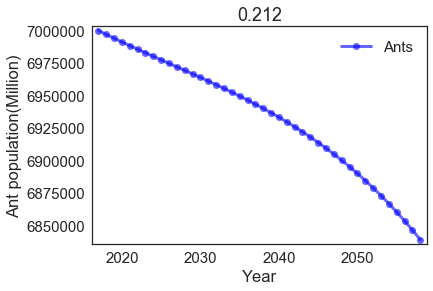

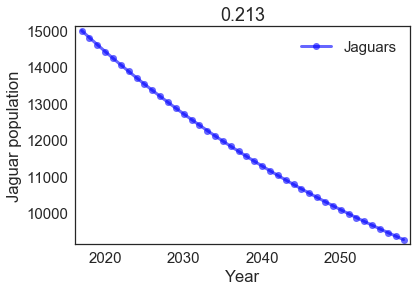

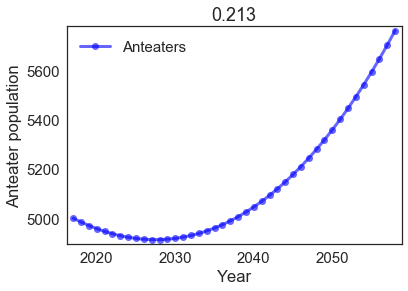

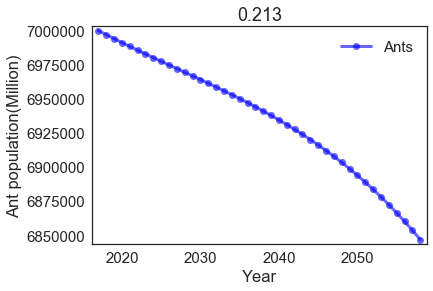

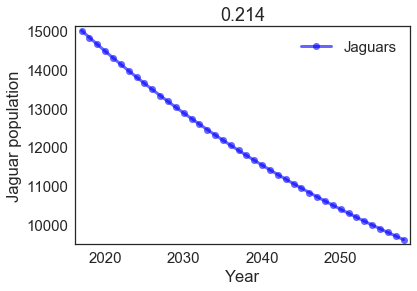

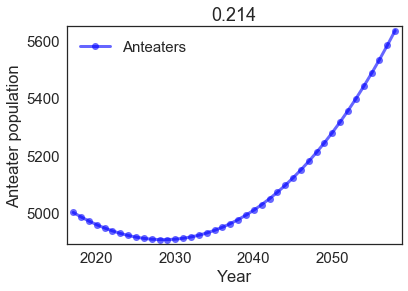

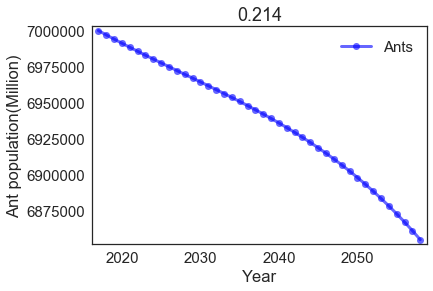

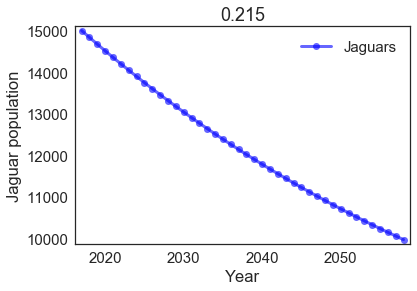

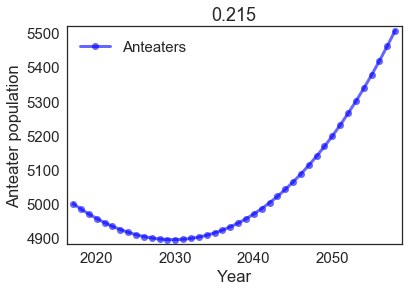

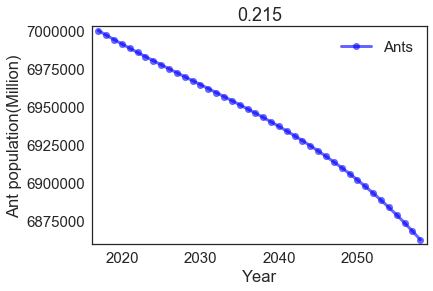

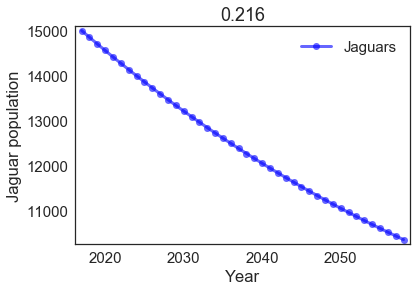

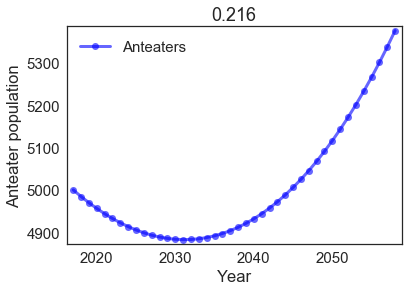

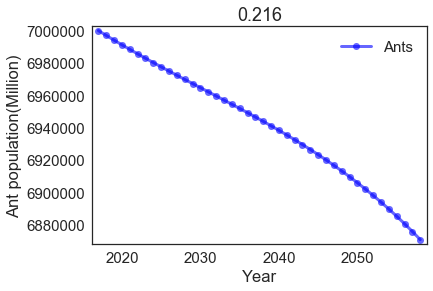

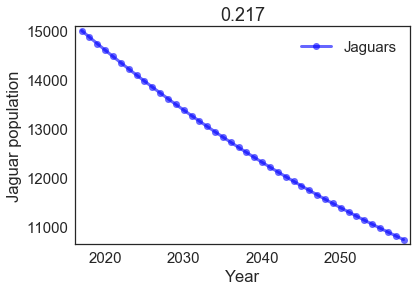

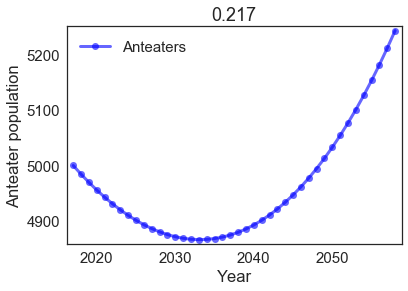

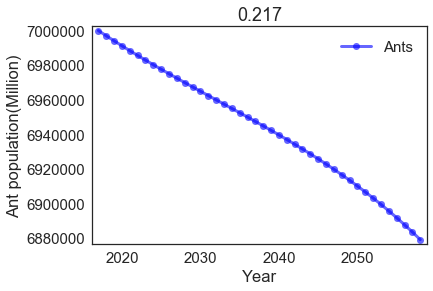

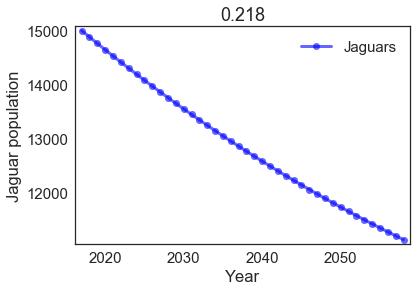

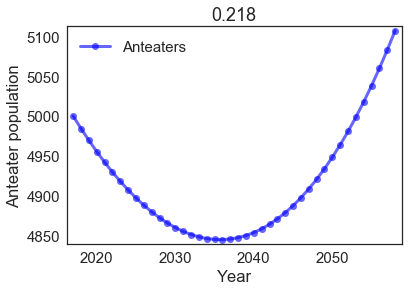

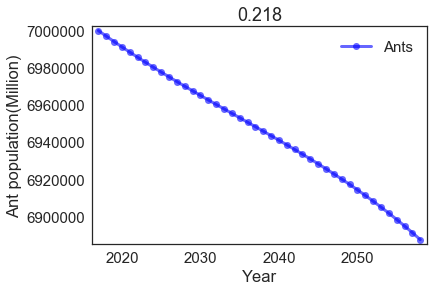

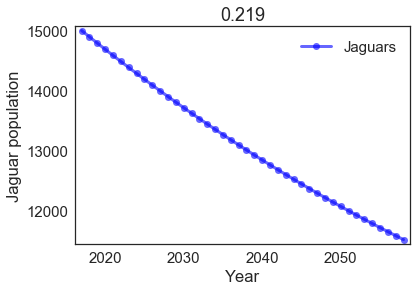

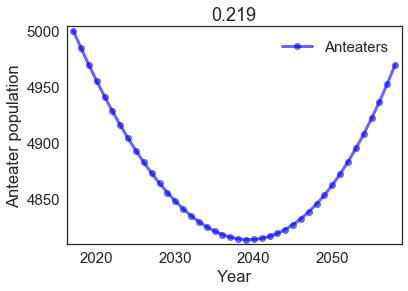

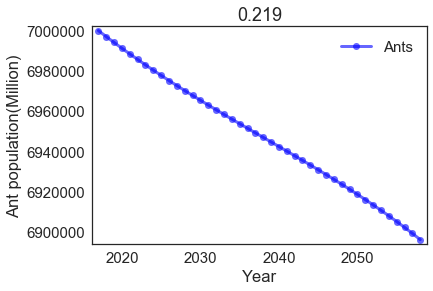

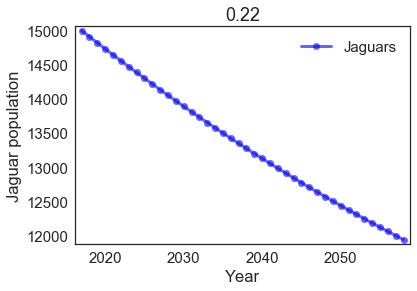

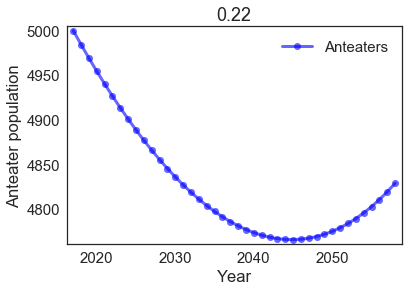

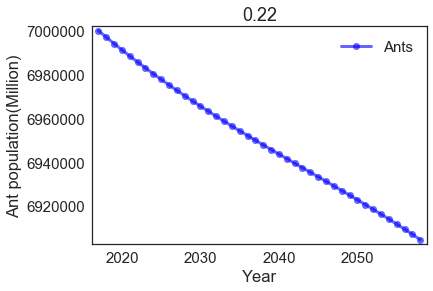

In [307]:
sweep_jag_birth_rate_plot()

In [372]:
def sweep_ant_death_rate_table(start = 0.18,end = 0.22,num_steps = 41):
    animals = System()
    animals.jag = TimeSeries()
    animals.ant = TimeSeries()
    animals.eater = TimeSeries()
    for i in linspace(start,end,num_steps):
        system.ant_death_rate = i
        run_simulation(system)
        animals.jag[i] = system.jag[system.t_end]
        animals.ant[i] = system.ant[system.t_end]
        animals.eater[i] = system.eater[system.t_end]
    return animals

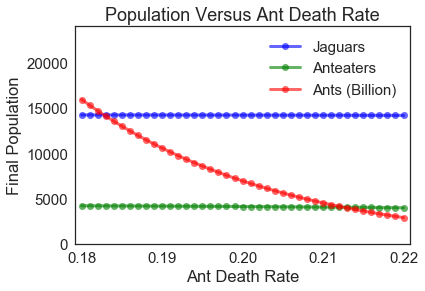

In [374]:
animals = sweep_ant_death_rate_table()
plot_results(animals,title = 'Population Versus Ant Death Rate',xLabel = 'Ant Death Rate')

In [366]:
def sweep_ant_birth_rate_table(start = 0.18,end = 0.22,num_steps = 41):
    animals = System()
    animals.jag = TimeSeries()
    animals.ant = TimeSeries()
    animals.eater = TimeSeries()
    for i in linspace(start,end,num_steps):
        system.ant_birth_rate = i
        run_simulation(system)
        animals.jag[i] = system.jag[system.t_end]
        animals.ant[i] = system.ant[system.t_end]
        animals.eater[i] = system.eater[system.t_end]
    return animals

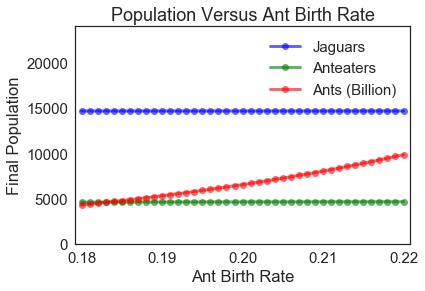

In [376]:
animals = sweep_ant_birth_rate_table()
plot_results(animals,title = 'Population Versus Ant Birth Rate',xLabel = 'Ant Birth Rate')